## Projekt Statystyczne Reguły Decyzyjne
### Projekt rozpoznawania dłoni w grze w kamień/papier/nożyce
 ![](http://azs.uni.lodz.pl/wp-content/uploads/2016/09/pnk-1.jpg)

#### Wykonali:
Szczepan Gabiec 101697, 
Kamil Sztukiewicz 101682, 
Mateusz Cieśliński 101737.

#### Opis projektu:
Celem projektu jest stworzenie sieci nauronowej służącej do rozpoznawania rodzaju ułożenia dłoni w grze papier/kamien/nożyce. W celu implementacji został wykorzystany framework uczenia mszynowego TensorFlow. 

Zbiór z którego korzystaliśmy pochodzi z :TODO **********************************************************************************************************
#### Zbiór danych - strukura
Wykorzystamy zbiór danych dotyczący rozpoznawania typu ułożenia dłoni, który został podzielony na zbiór treningowy i walidacyjny. Każdy ze zbiorów został sklasyfikowany na trzy grupy gdzie ułożenie dłoni odpowiadda gestom: nożyce, papier, kamień. Dodatkowo, został wykorzystany element generatora obrazów którego użycie pozwala na wygenerowania zmodyfikowanych (obrazy: obrócone, przesunięte, przybliżone) danych na podstawie zbioru postawowego. Zastosowanie tej techniki uodparnia sieć na te efekty. Wszytskie zbiory (treningowe i walidacyjne) zostały zmodyfikowane tak, że zdjęcia mają usystematyzowany rozmiar 100x150 . 
##### Modele sieci 
Model 1:
Model pierwszej sieci został przedstawiony poniżej. Zastosowano 18 warst, składających się z 4 różnych typów:
MaxPooling (MaxPooling2D)
Konwulucja (conv2d)
Warstwa zmieniająca z 2d na 1d (Flatten)
Warstawa ukryta (Dense)
Poszczególne parametry każdej z warsty zostały przedstawione poniżej w implentacji. 
W modelu sieci przedstawion poniżej zostało przestawione uproszczenie przedstawiające jedną linię pomiędzy warstwami, jednak w rzeczywistości są to połączenia NxM (N,M - liczb neuronów w poszczególnych warstawach). Zostały także użyte dwa rodzaje funkcji aktywacji:"relu" -użyta pomiędzy wewnętrznymi warstawami sieci; "softmax" - użyta w celu klasyfikacji wyjścia z sieci na jedną z trzech klas(papier, kamień, nożyce). 

 ![](https://i.ibb.co/xLKK0xW/porject.png)
Model 2:

![](https://i.ibb.co/vx0F5TX/porject-1-1.png)

##### Wnioski
Porówwnując dwa modele sieci można zauważyć zbliżoną wartość poprwności sieci zbadaną przy użyciu zbioru walidacyjnego, jednak w przypadku analizowania procesu uczenia widoczne jest szybsze osiągnięcie zadowalającej (ponad 70%) poprawności. Model 1 osiągnął poprawność na poziomie 70% dopiero przy 22 Epoce, gdzie Model 2 osiągnął podobny rezultat już w Epoce 12. Może to wynikać z różnej ilości warstw  wykorzystanych w modelach. Sieć o większej liczbie warstw potrzebuje więcej czasu. 
Po przeprowadzeniu procesu uczenia można zauważyć, że model z mniejszą ilością warst ma delikatnie lepsze wyniki klasyfikacji. 
Podobnie dla dwóch modeli proces uczenia przebiega w spsób podobny, funkcja start dążdy do podobnej wartości i niemożliwe jest osiągnięcie niższej wartości funkcji strat, a co za tym idzie poprawności sieci. 
Przykładowa predykcja została przedstawiona poniżej (dla każdego z Modeli sieci).

In [ ]:
# Import bibliotek wykorzystanych w projekcie 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from zipfile import ZipFile 
from shutil import move, rmtree
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [64]:
# Definicja zbiorów treningowego - train_dir i walidacyjnego - val_dir
dir_datasets = os.getcwd()
train_dir = os.path.join(dir_datasets, "train")
val_dir = os.path.join(dir_datasets, "val")

In [22]:
# Konfiguracja generatora obrazów zwiększającego ilość obrazów, moodyfikując skale, rotację, zoom - uodporniając sieć na obócone zdjęcie
train_data = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=.20,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

test_data = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=.20,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

In [23]:
# Ustawienie generatora aby generował dane na podstawie zbiorów treningowych zapisanych w train_dir
train_gen = train_data.flow_from_directory(
    train_dir,
    target_size=(100, 150),
    batch_size=256,
    class_mode="categorical"
)

val_gen = test_data.flow_from_directory(
    val_dir,
    target_size=(100, 150),
    batch_size=256,
    class_mode="categorical"
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [24]:
# Definicja pierwszego modelu sieci
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", 
                               input_shape=(100, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1028, activation="relu"),
        tf.keras.layers.Dense(2056, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax")
])

In [25]:
# Określanie straty, metryki i optymalizatora wykotrzysanego w procesie trenowania
model.compile(loss="poisson",
              optimizer=tf.keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

In [26]:
# Proces trenowania sieci
hist = model.fit(
    train_gen,
    steps_per_epoch=6,
    epochs=95,
    validation_data=val_gen,
    validation_steps=4,
    verbose=1,
    callbacks=tf.keras.callbacks.TerminateOnNaN(),
    workers=2
).history

Epoch 1/95
6/6 [==============================] - 32s 6s/step - loss: 0.6991 - accuracy: 0.3534 - val_loss: 0.6990 - val_accuracy: 0.3570
Epoch 2/95
6/6 [==============================] - 30s 5s/step - loss: 0.6993 - accuracy: 0.3302 - val_loss: 0.6984 - val_accuracy: 0.3570
Epoch 3/95
6/6 [==============================] - 29s 5s/step - loss: 0.6985 - accuracy: 0.3411 - val_loss: 0.6979 - val_accuracy: 0.3570
Epoch 4/95
6/6 [==============================] - 29s 6s/step - loss: 0.6975 - accuracy: 0.3533 - val_loss: 0.6973 - val_accuracy: 0.4485
Epoch 5/95
6/6 [==============================] - 30s 5s/step - loss: 0.6974 - accuracy: 0.4400 - val_loss: 0.6969 - val_accuracy: 0.4256
Epoch 6/95
6/6 [==============================] - 31s 5s/step - loss: 0.6965 - accuracy: 0.4176 - val_loss: 0.6961 - val_accuracy: 0.3913
Epoch 7/95
6/6 [==============================] - 30s 5s/step - loss: 0.6957 - accuracy: 0.4006 - val_loss: 0.6956 - val_accuracy: 0.3581
Epoch 8/95
6/6 [==================

6/6 [==============================] - 29s 5s/step - loss: 0.3979 - accuracy: 0.9312 - val_loss: 0.4068 - val_accuracy: 0.9268
Epoch 61/95
6/6 [==============================] - 29s 5s/step - loss: 0.3804 - accuracy: 0.9575 - val_loss: 0.4109 - val_accuracy: 0.9359
Epoch 62/95
6/6 [==============================] - 29s 4s/step - loss: 0.3935 - accuracy: 0.9447 - val_loss: 0.3908 - val_accuracy: 0.9416
Epoch 63/95
6/6 [==============================] - 29s 5s/step - loss: 0.3836 - accuracy: 0.9524 - val_loss: 0.3987 - val_accuracy: 0.9268
Epoch 64/95
6/6 [==============================] - 29s 6s/step - loss: 0.3989 - accuracy: 0.9472 - val_loss: 0.4020 - val_accuracy: 0.9336
Epoch 65/95
6/6 [==============================] - 29s 5s/step - loss: 0.3963 - accuracy: 0.9312 - val_loss: 0.3885 - val_accuracy: 0.9531
Epoch 66/95
6/6 [==============================] - 29s 5s/step - loss: 0.3912 - accuracy: 0.9479 - val_loss: 0.3940 - val_accuracy: 0.9394
Epoch 67/95
6/6 [======================

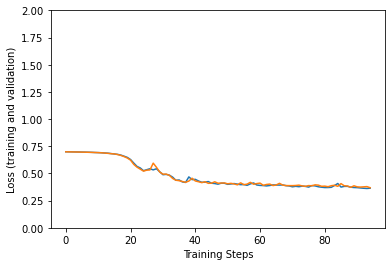

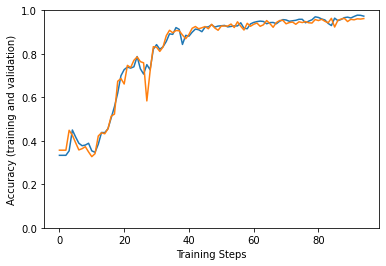

In [27]:
# Wizualizacja wyników procesu uczenia
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

paper


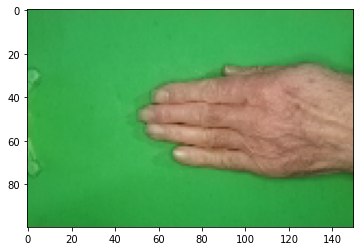

In [55]:
# Przykładowa predykcja sieci - wykorzystano zdjęcie papieru ze zbioru walidacyjnego
path = os.path.join(dir_datasets, "val\\paper\\O4H6QPX8bdwNiIie.png")
img = image.load_img(path, target_size=(100, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)

if classes[0][0] == 1.0:
    print("paper")
elif classes[0][1] == 1.0:
    print("rock")
else:
    print("scissors")
    


scissors


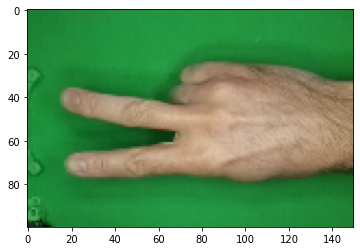

In [56]:
# Przykładowa predykcja sieci - wykorzystano zdjęcie nożyc ze zbioru walidacyjnego

path2 = os.path.join(dir_datasets, "val\\scissors\\ngrJl9cJoUVFdYwO.png")
   
img = image.load_img(path2, target_size=(100, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)

if classes[0][0] == 1.0:
    print("paper")
elif classes[0][1] == 1.0:
    print("rock")
else:
    print("scissors")

In [57]:
# Definicja drugiego modelu sieci
model_2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", 
                               input_shape=(100, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax")
])

In [58]:
# Określanie straty, metryki i optymalizatora wykotrzysanego w procesie trenowania
model_2.compile(loss="poisson",
              optimizer=tf.keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

In [59]:
# Proces trenowania sieci dwa
hist_2 = model_2.fit(
    train_gen,
    steps_per_epoch=6,
    epochs=95,
    validation_data=val_gen,
    validation_steps=4,
    verbose=1,
    callbacks=tf.keras.callbacks.TerminateOnNaN(),
    workers=2
).history

Epoch 1/95
6/6 [==============================] - 46s 7s/step - loss: 0.6993 - accuracy: 0.3541 - val_loss: 0.6982 - val_accuracy: 0.3135
Epoch 2/95
6/6 [==============================] - 34s 5s/step - loss: 0.6973 - accuracy: 0.3362 - val_loss: 0.6967 - val_accuracy: 0.3570
Epoch 3/95
6/6 [==============================] - 35s 5s/step - loss: 0.6981 - accuracy: 0.3415 - val_loss: 0.6932 - val_accuracy: 0.4794
Epoch 4/95
6/6 [==============================] - 35s 5s/step - loss: 0.6932 - accuracy: 0.4078 - val_loss: 0.6928 - val_accuracy: 0.3661
Epoch 5/95
6/6 [==============================] - 34s 6s/step - loss: 0.6897 - accuracy: 0.4308 - val_loss: 0.6882 - val_accuracy: 0.3970
Epoch 6/95
6/6 [==============================] - 37s 6s/step - loss: 0.6866 - accuracy: 0.4457 - val_loss: 0.6842 - val_accuracy: 0.3959
Epoch 7/95
6/6 [==============================] - 36s 7s/step - loss: 0.6837 - accuracy: 0.3509 - val_loss: 0.6785 - val_accuracy: 0.4085
Epoch 8/95
6/6 [==================

6/6 [==============================] - 33s 5s/step - loss: 0.3971 - accuracy: 0.9374 - val_loss: 0.4174 - val_accuracy: 0.9142
Epoch 61/95
6/6 [==============================] - 33s 5s/step - loss: 0.4098 - accuracy: 0.9185 - val_loss: 0.4348 - val_accuracy: 0.8867
Epoch 62/95
6/6 [==============================] - 33s 6s/step - loss: 0.4118 - accuracy: 0.9177 - val_loss: 0.4110 - val_accuracy: 0.9211
Epoch 63/95
6/6 [==============================] - 33s 5s/step - loss: 0.3984 - accuracy: 0.9335 - val_loss: 0.3973 - val_accuracy: 0.9382
Epoch 64/95
6/6 [==============================] - 33s 5s/step - loss: 0.3898 - accuracy: 0.9456 - val_loss: 0.4065 - val_accuracy: 0.9245
Epoch 65/95
6/6 [==============================] - 33s 5s/step - loss: 0.4039 - accuracy: 0.9309 - val_loss: 0.4010 - val_accuracy: 0.9279
Epoch 66/95
6/6 [==============================] - 31s 5s/step - loss: 0.3997 - accuracy: 0.9306 - val_loss: 0.4043 - val_accuracy: 0.9336
Epoch 67/95
6/6 [======================

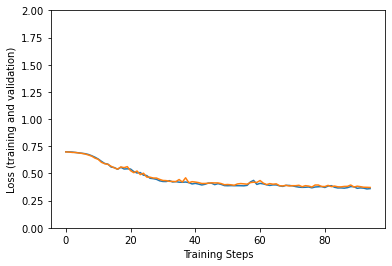

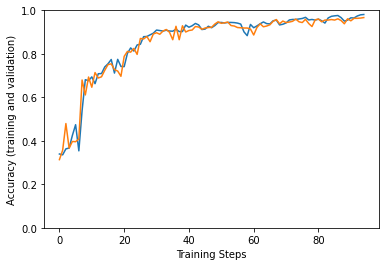

In [60]:
# Wizualizacja wyników procesu uczenia
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist_2["loss"])
plt.plot(hist_2["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist_2["accuracy"])
plt.plot(hist_2["val_accuracy"])

paper


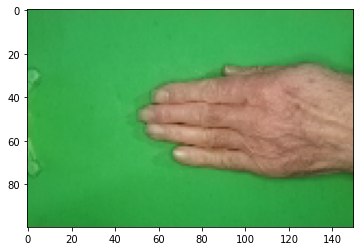

In [62]:
# Przykładowa predykcja sieci - wykorzystano zdjęcie papieru ze zbioru walidacyjnego
path = os.path.join(dir_datasets, "val\\paper\\O4H6QPX8bdwNiIie.png")
img = image.load_img(path, target_size=(100, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)

if classes[0][0] == 1.0:
    print("paper")
elif classes[0][1] == 1.0:
    print("rock")
else:
    print("scissors")
    

scissors


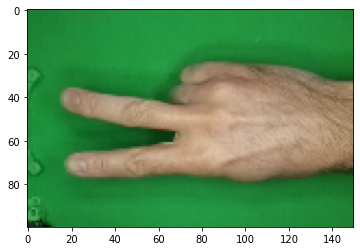

In [63]:
# Przykładowa predykcja sieci - wykorzystano zdjęcie nożyc ze zbioru walidacyjnego

path2 = os.path.join(dir_datasets, "val\\scissors\\ngrJl9cJoUVFdYwO.png")
   
img = image.load_img(path2, target_size=(100, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)

if classes[0][0] == 1.0:
    print("paper")
elif classes[0][1] == 1.0:
    print("rock")
else:
    print("scissors")